Портнов Александр, @AlSePort

# Описание проекта
**Данные ([ссылка](https://disk.yandex.ru/d/BBEphK0EHSJ5Jw)):**
- `base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base, …) и вектор признаков размерностью 72.
- `train.csv` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков и id товара из `base.csv`, который максимально похож на него (по мнению экспертов).
- `validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из `base.csv`
- `validation_answer.csv` - правильные ответы к файлу `validation.csv`.  

**Задача:**  
- разработать алгоритм, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base.csv`;
- оценить качество алгоритма по метрике `accuracy@5`


# EDA

## Подготовка к работе

Импорт необходимых библиотек

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import warnings
from IPython.core.display import display, HTML
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import (MinMaxScaler, 
                                   StandardScaler, 
                                   RobustScaler, 
                                   PowerTransformer)
import faiss

In [2]:
# Широкоформатный Jupyter
display(HTML("<style>.container { width:90% !important; }</style>"))

# Отключаем предупреждения
warnings.filterwarnings("ignore")

# отображение всех колонок датасета
pd.set_option('display.max_columns', 80)

## Загрузка и чтение данных

Считываем файлы

In [3]:
df_base = pd.read_csv('base.csv', index_col=0)
df_train = pd.read_csv('train.csv', index_col=0)
df_valid = pd.read_csv('validation.csv', index_col=0)
df_valid_answer = pd.read_csv('validation_answer.csv', index_col=0)

Выводим информацию на экран

In [4]:
display(df_base.head())
display(df_train.head())
display(df_valid.head())
display(df_valid_answer.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,-30.800995,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,-53.147078,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [5]:
display(df_base.info())
display(df_train.info())
display(df_valid.info())
display(df_valid_answer.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


None

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

None

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

None

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None

`df_base` содержит 2918139 записей и 72 признака  
`df_train` содержит 100000 записей, 72 признака и столбец `Target` с правильными ответами  
`df_valid` содержит 100000 записей и 72 признака  
`df_valid_answer` содержит 100000 и столбец `Expected` с правильными ответами  

Все признаки имеют тип `float64`

## Подготовка данных

Для уменьшения объема используемой памяти приведем признаки в датафреймах `df_base` и `df_train` к типу `float32`.  

In [6]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

In [7]:
df_base = df_base.astype(dict_base)
df_train = df_train.astype(dict_train)

Проверим тип данных признаков

In [8]:
display(df_base.dtypes)
display(df_train.dtypes)

0     float32
1     float32
2     float32
3     float32
4     float32
       ...   
67    float32
68    float32
69    float32
70    float32
71    float32
Length: 72, dtype: object

0         float32
1         float32
2         float32
3         float32
4         float32
           ...   
68        float32
69        float32
70        float32
71        float32
Target     object
Length: 73, dtype: object

Разделим `df_train` на признаки и ответы. Создадим два датафрейма:
- `targets` - ответы
- `df_train_nt` - признаки

In [11]:
targets = df_train['Target']
df_train_nt = df_train.drop('Target', axis=1)

## Распределение признаков

Посмотрим на распределение признаков в `df_base`

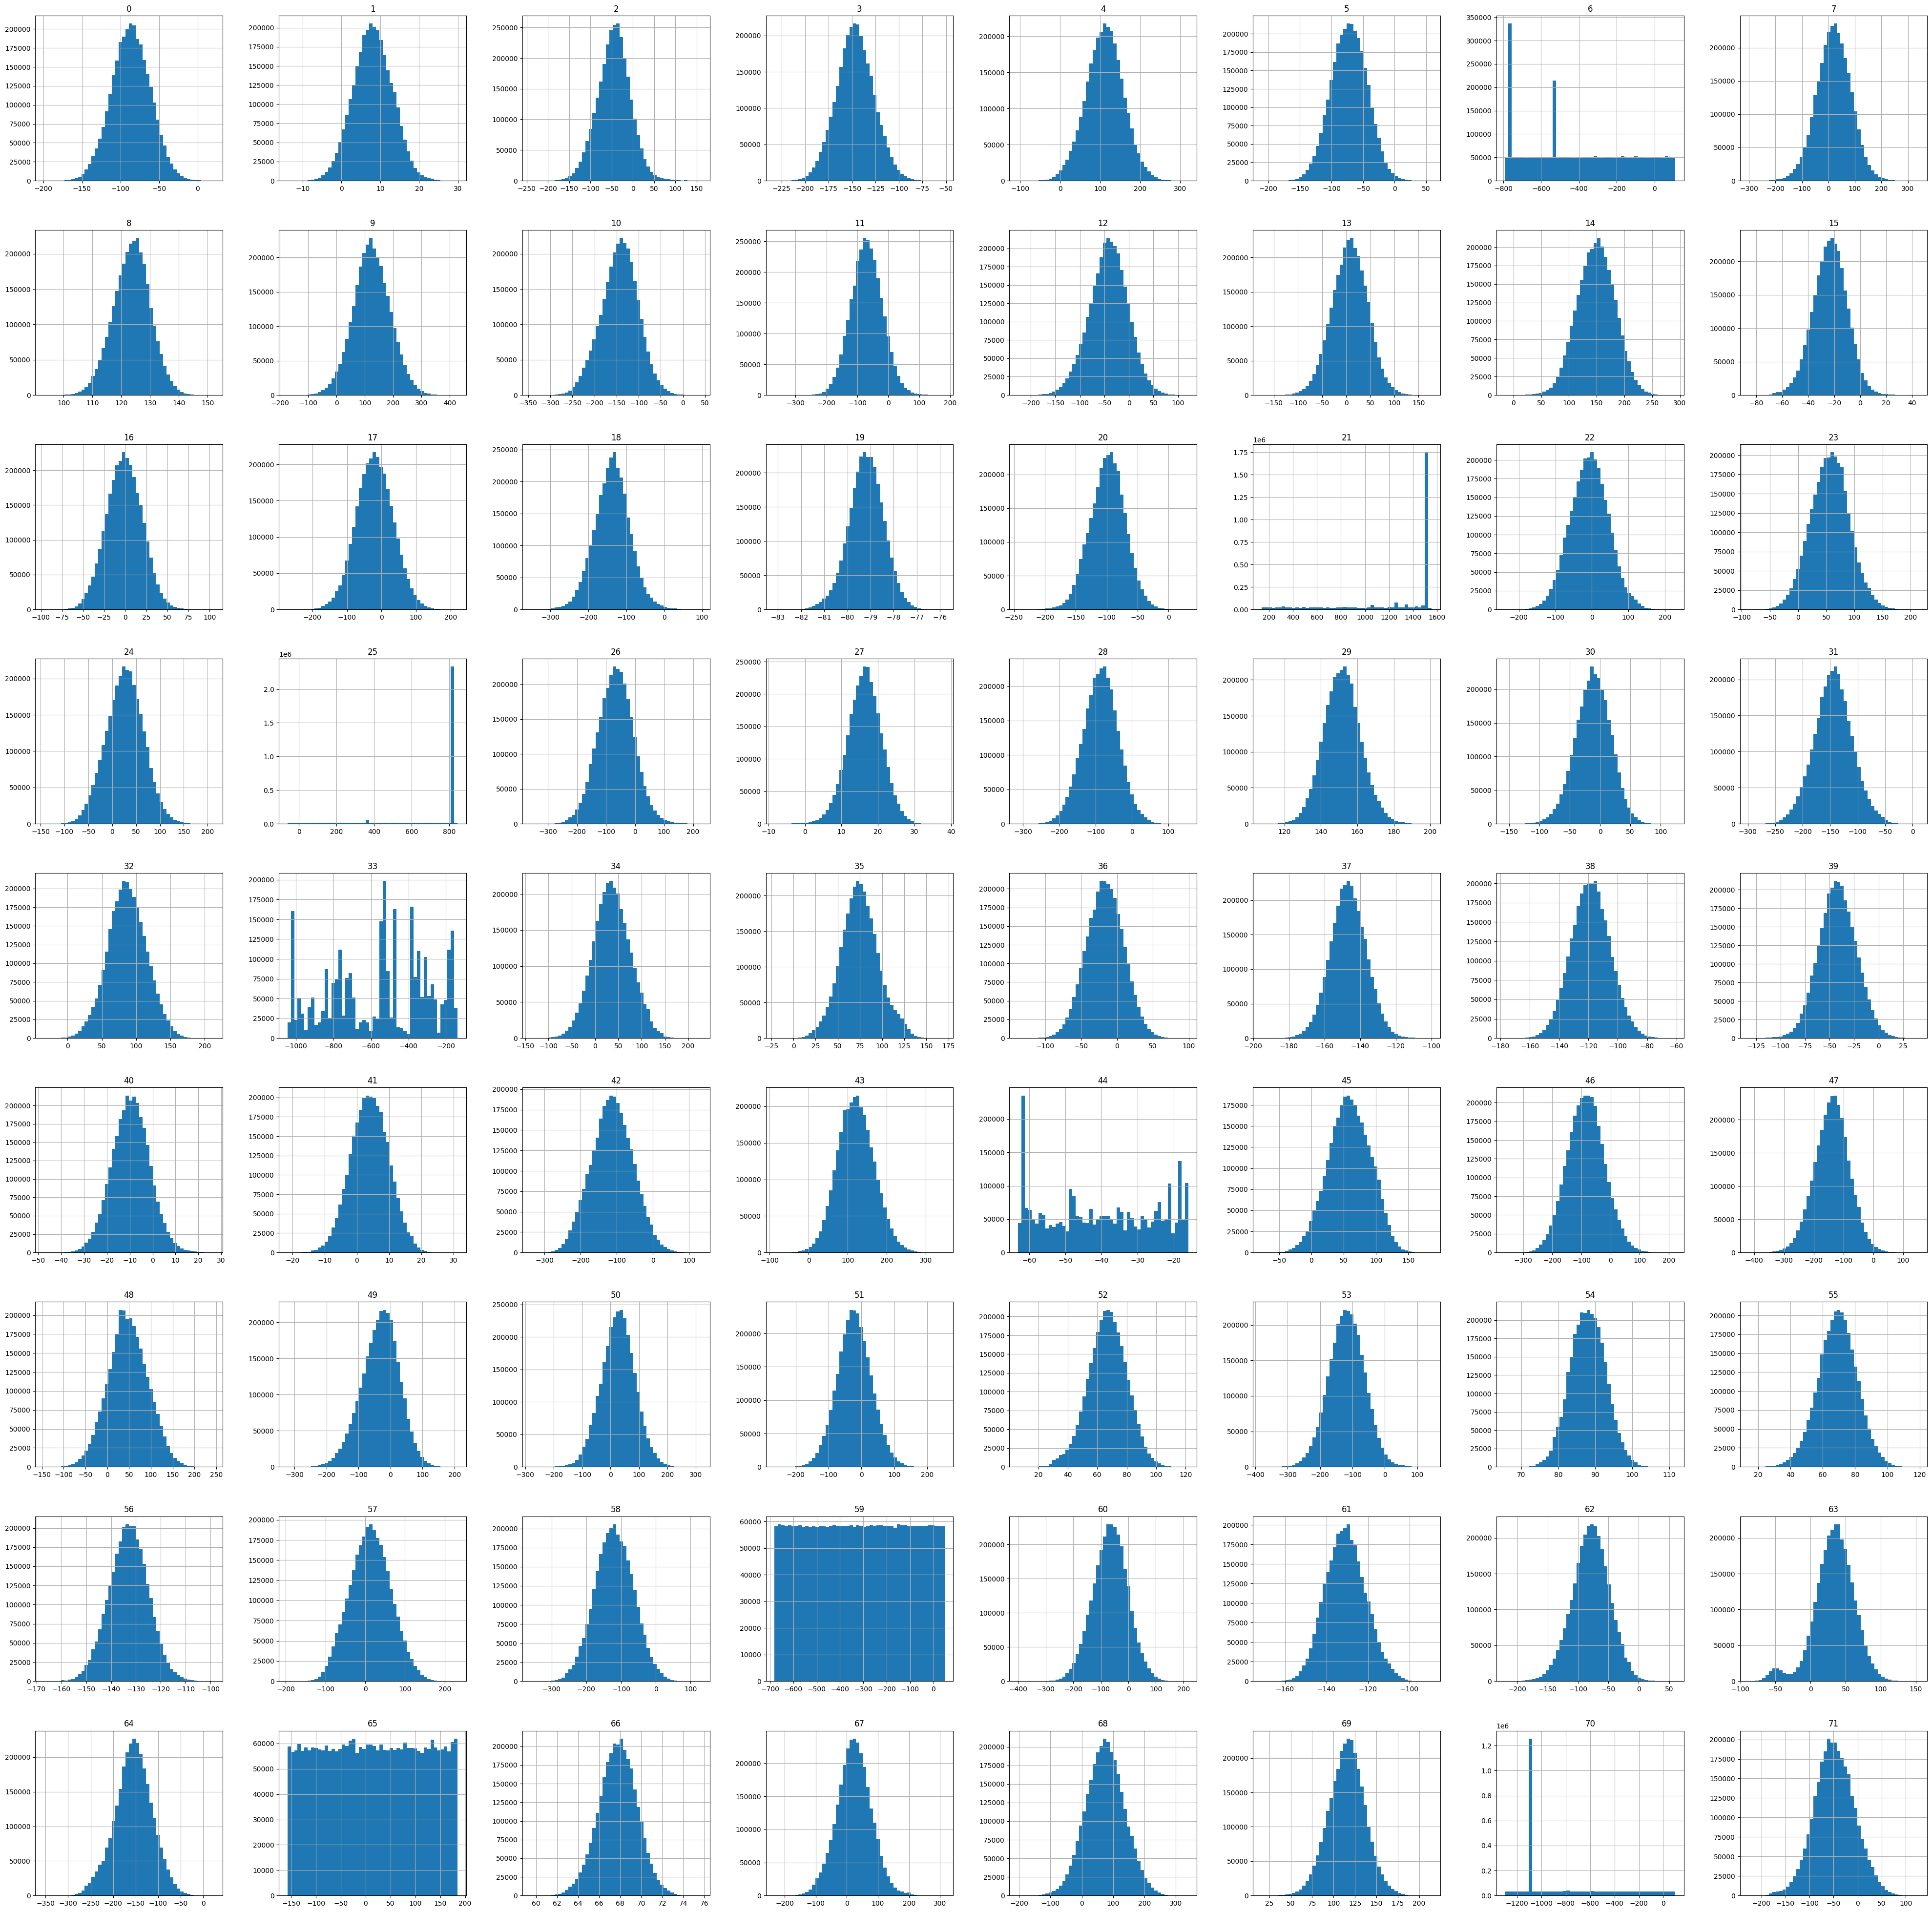

In [10]:
df_base.hist(bins=50, figsize=[50,50])
plt.show()

Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Но с ними "разберемся" позже.

## Промежуточный вывод  
Нам предоставили анонимизированный набор данных:  
- base.csv содержит 2918139 записей и 72 признака
- train.csv содержит 100000 записей, 72 признака и столбец Target с правильными ответами
- valid.csv содержит 100000 записей и 72 признака
- valid_answer.csv содержит 100000 и столбец Expected с правильными ответами  

Для уменьшения объема используемой памяти мы привели признаки в датафреймах `df_base` и `df_train` к типу `float32`.  

Выяснили, что признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение.

# Разработка модели

## FAISS  - базовая модель

### Создание модели

In [12]:
def base_model(df_b, df_t):
    '''
    Функция для расчета accuracy@5
    с помошью базовой модели FAISS
    на выборке с 1000000 значений
    '''
    dim = df_b.shape[1]
    index_fl2 = faiss.IndexFlatL2(dim)
    index_fl2.add(np.ascontiguousarray(df_b.values[:1000000, :]).astype('float32'))
    base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
    r, idx = index_fl2.search(np.ascontiguousarray(df_t.values).astype('float32'), 5)
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    return (100 * acc / len(idx))

### Проверка базовой модели

In [13]:
a_base_model = base_model(df_base, df_train_nt)
print('Метрика accuracy@5 на базовой модели =', a_base_model)

Метрика accuracy@5 на базовой модели = 10.023


Метрика accuracy@5 на базовой модели = 10.023

## Масштабирование признаков

Для масштабирования признаков выберем одно из средств масштабирования:
- `StandardScaler`  
- `RobustScaler`  
- `PowerTransformer`
- `MinMaxScaler`  

Сравним их.

In [14]:
def scal(scal):
    '''
    Функция для масштабирования признаков.
    '''
    scaler = scal()
    scaler.fit(df_base)
    base_scal = scaler.transform(df_base)
    train_scal = scaler.transform(df_train_nt)
    train_scal = pd.DataFrame(train_scal, columns = df_train_nt.columns)
    base_scal = pd.DataFrame(base_scal, columns = df_base.columns)
    a_base_model = base_model(base_scal, train_scal) # обратимся к функции base_model для расчета accuracy@5
    return a_base_model

In [15]:
# Создадим таблицу для сравнения различных средств масштабирования
table_scal = pd.DataFrame(columns=['scaler', 'accuracy@5'])

In [16]:
table_scal.loc[len(table_scal.index)] = ['StandardScaler', scal(StandardScaler)]

In [17]:
table_scal.loc[len(table_scal.index)] = ['RobustScaler', scal(RobustScaler)]

In [18]:
table_scal.loc[len(table_scal.index)] = ['PowerTransformer', scal(PowerTransformer)]

In [19]:
table_scal.loc[len(table_scal.index)] = ['MinMaxScaler', scal(MinMaxScaler)]

In [20]:
table_scal.sort_values('accuracy@5', ascending=False)

,scaler,accuracy@5
2,PowerTransformer,48.787
0,StandardScaler,48.740
1,RobustScaler,38.786
3,MinMaxScaler,26.960


||scaler|	accuracy@5|
|-|-|-|
2|	PowerTransformer|	48.787|
0|	StandardScaler|	48.740|
1|	RobustScaler|	38.786|
3|	MinMaxScaler|	26.960|

`PowerTransformer` и `StandardScaler` показали почти одинаковый результат:  
- `PowerTransformer`: 48.787;
- `StandardScaler`: 48.740  

Но данные, смасштабированные через `StandardScaler`, обрабатываются гораздо быстрее (`1m 57.7s` против `6m 22s`).  
Так что остановимся на `StandardScaler`

In [27]:
scaler = StandardScaler()
scaler.fit(df_base)
base_scal = scaler.transform(df_base)
train_scal = scaler.transform(df_train_nt)
train_scal = pd.DataFrame(train_scal, columns = df_train_nt.columns)
base_scal = pd.DataFrame(base_scal, columns = df_base.columns)

## Удаление признаков

В п.2.4 мы обнаружили признаки с ненормальным распределением.  
Удалим каждый такой признак по очереди и посмотрим как изменится метрика.

In [24]:
# Создадим сравнительную таблицу
table_del_f = pd.DataFrame({'feature': ['Все'],
                      'accuracy@5': [a_base_model]})

In [25]:
features_del = ['6', '21', '25', '33', '44', '59', '65', '70']

In [28]:
for i in features_del:
    a = base_model(base_scal.drop(i, axis=1), train_scal.drop(i, axis=1))
    table_del_f.loc[len(table_del_f.index)] = [i, a]
    print(i, ':', a)

6 : 48.505
21 : 49.235
25 : 49.248
33 : 50.029
44 : 48.924
59 : 49.168
65 : 49.111
70 : 48.363


In [29]:
table_del_f.sort_values('accuracy@5', ascending=False)

,feature,accuracy@5
4,33,50.029
3,25,49.248
2,21,49.235
6,59,49.168
7,65,49.111
5,44,48.924
0,Все,48.740
1,6,48.505
8,70,48.363


||	feature|	accuracy@5|
|-|-|-|
4|	33|	50.029|
3|	25|	49.248|
2|	21|	49.235|
6|	59|	49.168|
7|	65|	49.111|
5|	44|	48.924|
0|	Все|	48.740|
1|	6|	48.505|
8|	70|	48.363|  

При удалении признаков 21, 25, 33, 44, 59, 65 значение метрики выросло.  
При удалении признаков 6 и 70 значение метрики упало.  

Избавимся от признаков 21, 25, 33, 44, 59, 65.

In [30]:
features_del = ['21', '25', '33', '44', '59', '65']

In [31]:
base_scal.drop(features_del, axis=True, inplace=True)

In [32]:
train_scal.drop(features_del, axis=True, inplace=True)

Проверим как изменилось значение `accuracy@5` без "лишних" признаков.

In [33]:
print(base_model(base_scal, train_scal))

52.003


После удаления признаков `accuracy@5` = `52.003`. Немного выросло (было 48.740).

## Кластеризация

### Определение оптимального количества кластеров

При помощи библиотеки `MiniBatchKMeans` определим оптимальное количество кластеров методом "Локтя".

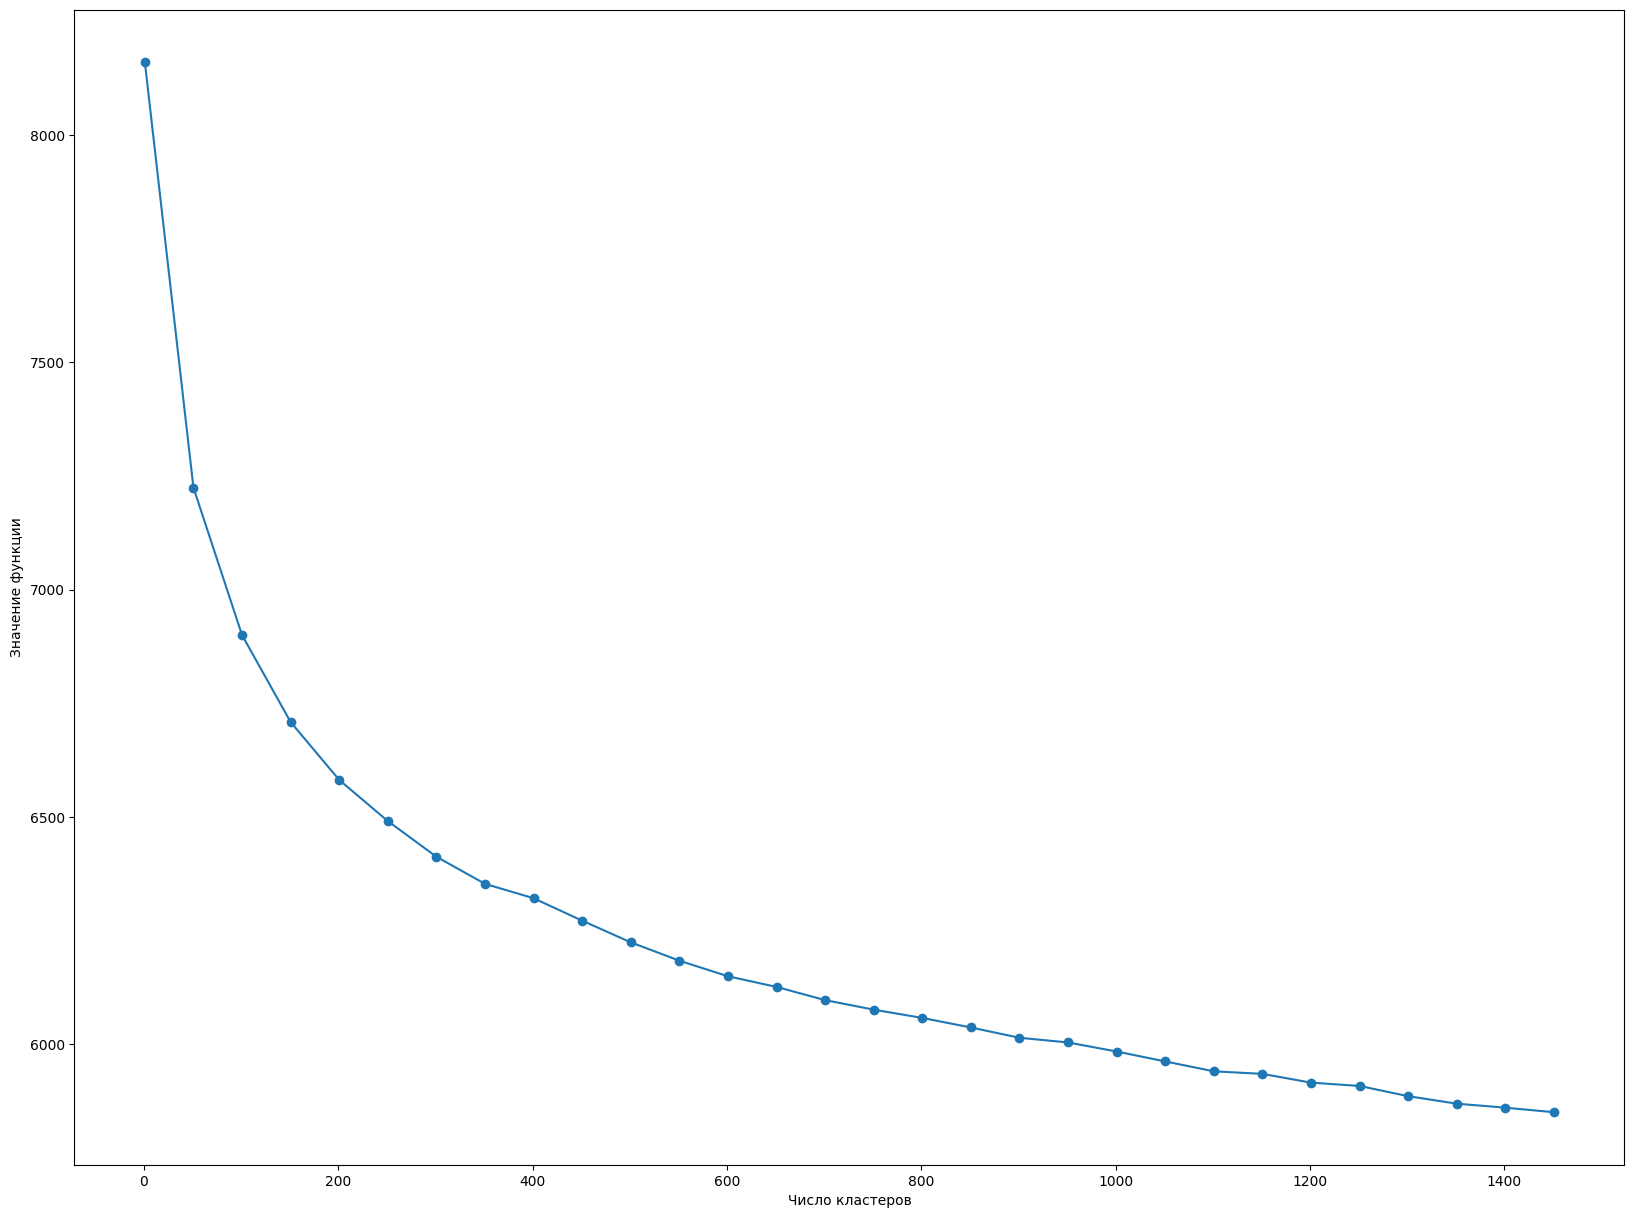

In [60]:
inertia = []
for k in range(1,1500,50):
    mbk  = MiniBatchKMeans(n_clusters=k,init='random', random_state=12345).fit(base_scal.iloc[:1000000, :])
    inertia.append(np.sqrt(mbk.inertia_))
plt.figure(figsize=(20,15))
plt.plot(range(1,1500,50), inertia, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Значение функции');
plt.show()

"На глаз" оптимальное количество кластеров находится в промежутке от 150 до 350. Проверим перебором.

In [37]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [49]:
# Создадим сравнительную таблицу
table_cell = pd.DataFrame(columns=['cells', 'accuracy@5'])
# Создадим список с количеством кластеров для перебора
n_cells = [150, 200, 250, 300, 350]

In [50]:
for cell in n_cells:
    cells = cell
    dim = base_scal.shape[1]
    quantizer = faiss.IndexFlatL2(dim)
    index_fl2 = faiss.IndexIVFFlat(quantizer, dim, cells)
    index_fl2.train(np.ascontiguousarray(base_scal.iloc[:1000000, :]).astype('float32'))
    index_fl2.add(np.ascontiguousarray(base_scal).astype('float32'))
    r, idx = index_fl2.search(np.ascontiguousarray(train_scal.values).astype('float32'), 5)
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    table_cell.loc[len(table_cell.index)] = [cell, 100 * acc / len(idx)]
    print(cell, ':', 100 * acc / len(idx))

150 : 63.078
200 : 63.158
250 : 62.511
300 : 62.598
350 : 62.174


In [51]:
table_cell.sort_values('accuracy@5', ascending=False)

,cells,accuracy@5
1,200.0,63.158
0,150.0,63.078
3,300.0,62.598
2,250.0,62.511
4,350.0,62.174


||	cells|	accuracy@5|
|-|-|-|
|1|	200.0|	63.158|
|0|	150.0|	63.078|
|3|	300.0|	62.598|
|2|	250.0|	62.511|
|4|	350.0|	62.174|

Как мы видим, оптимальное количество кластеров = `200`

Теперь подберем оптимальное значение для параметра `nprobe`.  
Можно брать nprobe равным количеству центроид в индексе, тогда это будет эквивалентно поиску полным перебором, точность будет наибольшая, но скорость поиска заметно уменьшится.  

Сравним значение метрики accuracy@5 и время выполнения в зависимости от значения nprobe.

In [52]:
cells = 200
dim = base_scal.shape[1]
quantizer = faiss.IndexFlatL2(dim)
index_fl2 = faiss.IndexIVFFlat(quantizer, dim, cells)
index_fl2.nprobe = 200
index_fl2.train(np.ascontiguousarray(base_scal).astype('float32'))
index_fl2.add(np.ascontiguousarray(base_scal).astype('float32'))

In [53]:
r, idx = index_fl2.search(np.ascontiguousarray(train_scal.values).astype('float32'), 5)
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(100 * acc / len(idx))

71.918


При nprobe = 200, accuracy@5 = 71.918. Время расчета 32m 4s.

In [54]:
cells = 200
dim = base_scal.shape[1]
quantizer = faiss.IndexFlatL2(dim)
index_fl2 = faiss.IndexIVFFlat(quantizer, dim, cells)
index_fl2.nprobe = 150
index_fl2.train(np.ascontiguousarray(base_scal).astype('float32'))
index_fl2.add(np.ascontiguousarray(base_scal).astype('float32'))

In [55]:
r, idx = index_fl2.search(np.ascontiguousarray(train_scal.values).astype('float32'), 5)
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(100 * acc / len(idx))

71.914


При nprobe = 150, accuracy@5 = 71.914. Время расчета 27m 47s.

In [56]:
cells = 200
dim = base_scal.shape[1]
quantizer = faiss.IndexFlatL2(dim)
index_fl2 = faiss.IndexIVFFlat(quantizer, dim, cells)
index_fl2.nprobe = 100
index_fl2.train(np.ascontiguousarray(base_scal).astype('float32'))
index_fl2.add(np.ascontiguousarray(base_scal).astype('float32'))

In [57]:
r, idx = index_fl2.search(np.ascontiguousarray(train_scal.values).astype('float32'), 5)
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(100 * acc / len(idx))

71.862


При nprobe = 100, accuracy@5 = 71.862. Время расчета 18m 20s.

In [58]:
cells = 200
dim = base_scal.shape[1]
quantizer = faiss.IndexFlatL2(dim)
index_fl2 = faiss.IndexIVFFlat(quantizer, dim, cells)
index_fl2.nprobe = 50
index_fl2.train(np.ascontiguousarray(base_scal).astype('float32'))
index_fl2.add(np.ascontiguousarray(base_scal).astype('float32'))

In [59]:
r, idx = index_fl2.search(np.ascontiguousarray(train_scal.values).astype('float32'), 5)
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(100 * acc / len(idx))

71.714


При nprobe = 50, accuracy@5 = 71.714. Время расчета 9m 15s.

Сравнительная таблица:
|nprobe|accuracy@5|Время|
|-|-|-|
|200|71.918|32m 4s|
|150|71.914|27m 47|
|100|71.862|18m 20s|
|50|71.714|9m 15s|

На мой взгляд, оптимальное соотношение время/качество nprobe = 100. Его и возьмем для теста.

## Промежуточный вывод.  
При разработке модели мы определили:
- масштабирование признаков проводим с помощью `StandardScaler`
- количество кластеров = 200
- nprobe = 100  

Так же установили, что при удалении признаков 21, 25, 33, 44, 59, 65 значение целевой метрики возрастает.  

Перейдем к тестированию нашей модели.

# Тестирование финальной модели.

## Подготовка данных для тестирования

In [61]:
# Приведение признаков к типу float32
df_valid = df_valid.astype(dict_base)

In [62]:
# Масштабируем признаки
valid_scal = scaler.transform(df_valid)
valid_scal = pd.DataFrame(valid_scal, columns = df_valid.columns)
valid_scal.drop(features_del, axis=True, inplace=True)
valid_scal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,66,67,68,69,70,71
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,0.269789,-1.387780,-0.429176,-0.832212,0.056796,2.380963,0.890877,-0.293647,-1.691501,-2.270031,1.622037,1.213946,0.298333,-0.130599,0.543940,0.961781,0.135958,0.453171,-1.078517,2.086161,-0.141311,-0.868026,-0.902899,-0.502330,0.751393,-0.572587,-1.081679,0.545730,1.359597,1.223365,1.482423,0.536125,-2.537811,-0.089837,-1.154544,-0.245028,-0.910379,-0.244107,0.652803,1.292840,0.977971,-0.730510,0.693352,-1.031937,-0.086616,1.767701,-1.413223,0.115241,0.676228,0.275453,0.817489,0.693550,0.597167,-0.020121,-0.777845,-1.659674
1,1.304502,0.950910,0.033969,0.615646,0.067603,-0.657373,-1.352459,0.679613,0.540216,-1.107069,-0.253738,0.115879,-0.284999,-1.119722,-0.010871,0.052248,0.772891,-0.696383,-0.350519,-0.848263,-0.099495,1.701324,1.290572,0.772640,-0.984945,-1.273988,0.986361,1.352757,-2.287789,-0.728072,0.583843,-0.504559,-2.822255,-0.859436,-0.290972,-1.542951,0.302277,0.818102,-0.302876,-0.522193,1.478784,0.983431,-0.168406,-2.098551,0.099781,0.040793,-0.204944,0.399040,-0.011794,-0.793010,1.417167,-1.572053,1.001930,-0.751675,-1.024149,-0.548876,-1.135690,-0.013756,-0.142349,-0.334949,1.631022,-1.617587,0.360549,0.369533,0.142436,0.545701
2,0.886027,-2.434901,0.955216,-1.185497,-0.320843,0.341078,-1.352459,1.045290,1.193478,0.690080,-1.851159,0.751821,0.833501,-0.144887,-0.467334,-1.387473,0.731674,0.020413,-1.464054,1.358534,0.058460,0.016561,-0.632596,-2.125814,0.862182,0.569358,1.056717,-0.036283,-0.203195,-0.047514,-2.573511,0.079546,-0.589553,1.021546,0.271998,-0.349631,0.252462,-0.490686,1.518687,-0.057851,1.186022,1.387486,-0.091278,-0.418202,1.530935,0.779965,0.733515,0.286875,-0.251659,-0.108827,0.750399,-0.790395,0.427294,-0.509959,-0.626286,1.127774,0.402835,-1.831225,0.140946,-0.118026,-0.044549,1.128563,1.021715,1.204945,1.311027,-0.555197
3,-0.524576,1.623911,1.408637,-0.071830,-0.595916,-2.190386,1.659459,-0.613543,-1.359610,-0.764409,0.692479,-0.029673,-0.618126,0.458758,-2.928977,0.645909,0.768337,-0.516685,-0.843595,0.658296,-1.455101,0.201207,0.531297,-0.808846,0.215669,-0.144094,0.665539,-0.042166,1.129380,0.279795,-0.793415,2.389424,-0.352331,-0.247453,0.073895,2.403730,1.563555,-1.551343,-0.614648,-1.752528,1.062872,1.269804,-1.737581,-0.052889,0.271881,1.814621,1.560293,1.558166,-0.874238,-1.155161,-0.981859,-0.261218,2.412812,-1.377907,1.145201,0.783558,0.268197,0.058666,0.373992,0.540055,1.695932,0.000596,0.949135,1.307485,-0.000064,-0.996489
4,0.269032,-1.704743,0.739119,-1.221980,1.168059,1.550401,1.568739,0.218922,0.821217,-0.347213,1.605413,0.849138,1.942547,1.184546,0.258596,-0.047378,-1.547558,0.353403,-1.202071,-0.609572,0.226007,0.978453,1.887435,0.500426,-0.259693,1.020725,1.101449,-0.244365,0.414926,1.339522,-0.197446,-0.672819,-1.204816,1.323251,-1.358872,-0.825902,-0.711258,0.840518,-0.732855,1.253499,-0.615906,0.458316,1.181002,-0.644068,-0.498490,1.376932,0.422042,3.144028,-0.630804,-1.783906,0.675949,-2.095521,-0.305781,-0.640851,0.233961,0.856405,-0.512342,-1.469227,0.427148,0.498123,1.549868,-0.148400,1.297723,-0.654827,-0.966634,-1.856774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.589177,-0.289879,1.344941,1.537359,-0.674999,0.842355,1.378686,1.367212,-0.150169,-0.323048,-0.841683,0.188962,-0.251590,-0.650348,-0.920503,-0.120639,0.054390,0.855915,-0.759439,1.382456,0.657766,0.769678,2.693913,-0.478815,-1.486739,-0.515645,-0.965466,0.788646,1.971153,0.432075,-1.540784,-0.944680,0.072951,-1.010830,-0.388587,-1.806027,1.270215,1.981180,0.882407,-1.443553,0.132108,0.374044

In [63]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [64]:
# Выделяем таргет в отдельный датафрейм
target_valid = df_valid_answer['Expected']
target_valid

Id
100000-query    2676668-base
100001-query      91606-base
100002-query     472256-base
100003-query    3168654-base
100004-query      75484-base
                    ...     
199995-query     967418-base
199996-query    1344948-base
199997-query    1690782-base
199998-query     341779-base
199999-query     336472-base
Name: Expected, Length: 100000, dtype: object

## Тестирование

In [65]:
cells = 200
dim = base_scal.shape[1]
quantizer = faiss.IndexFlatL2(dim)
index_fl2 = faiss.IndexIVFFlat(quantizer, dim, cells)
index_fl2.nprobe = 100
index_fl2.train(np.ascontiguousarray(base_scal).astype('float32'))
index_fl2.add(np.ascontiguousarray(base_scal).astype('float32'))

In [66]:
r, idx = index_fl2.search(np.ascontiguousarray(valid_scal.values).astype('float32'), 5)
acc = 0
for target, el in zip(target_valid.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(100 * acc / len(idx))

71.741


71.741

accuracy@5: 
- на тренировочной выборке 71.862
- на тестовой выборке 71.741

# Вывод

Нам предоставили анонимизированный набор данных:  
- base.csv содержит 2918139 записей и 72 признака
- train.csv содержит 100000 записей, 72 признака и столбец Target с правильными ответами
- valid.csv содержит 100000 записей и 72 признака
- valid_answer.csv содержит 100000 и столбец Expected с правильными ответами  

Для уменьшения объема используемой памяти мы привели признаки в датафреймах `df_base` и `df_train` к типу `float32`.  

Выяснили, что признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение.

При разработке алгоритма на основе FAISS мы определили:
- масштабирование признаков проводим с помощью `StandardScaler`
- количество кластеров = 200
- nprobe = 100  

Установили, что при удалении признаков 21, 25, 33, 44, 59, 65 значение целевой метрики возрастает.

Применили наш алгоритм на тренировочных и тестовых данных и получили следующие значения accuracy@5
- на тренировочной выборке 71.862
- на тестовой выборке 71.741  

Как видим, значение почти не упало, так что можем считать наш алгоритм рабочим!